## Experiment 1

In [1]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

# ImageDataGenerator generates batches of tensor image data with real-time data augmentation.

train_generator = ImageDataGenerator(
    rescale=1/255.,              # normalize pixel values between 0-1
    brightness_range=[0.1, 0.7], # specify the range in which to decrease/increase brightness
    width_shift_range=0.5,       # shift the width of the image 50%
    rotation_range=90,           # random rotation by 90 degrees
    horizontal_flip=True,        # 180 degree flip horizontally
    vertical_flip=True,          # 180 degree flip vertically
    validation_split=0.15        # 15% of the data will be used for validation at end of each epoch
)

In [2]:
BATCH_SIZE = 32

# flow_from_directory() takes the path to a directory & generates batches of augmented data.

traingen = train_generator.flow_from_directory('data/train', target_size=(128, 128), batch_size=BATCH_SIZE, class_mode='categorical', subset='training', shuffle=True, seed=42)

validgen = train_generator.flow_from_directory('data/valid', target_size=(128, 128), batch_size=BATCH_SIZE, class_mode='categorical', subset='validation', shuffle=True, seed=42)

Found 2550 images belonging to 6 classes.
Found 77 images belonging to 6 classes.


#### Define CNN Architecture in Keras

In [3]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation
from keras.regularizers import l1_l2

model = Sequential()

#### Input Layer ####
model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu', input_shape=(128, 128, 3)))

#### Convolutional Layers ####
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))  # Pooling


model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))


model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(Activation('relu'))
model.add(MaxPooling2D((2,2)))



#### Fully-Connected Layer ####
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(6, activation='softmax'))

model.summary() # a handy way to inspect the architecture

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 126, 126, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 63, 63, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 61, 61, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                    

In [4]:
!pip install livelossplot


[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


#### Training the network

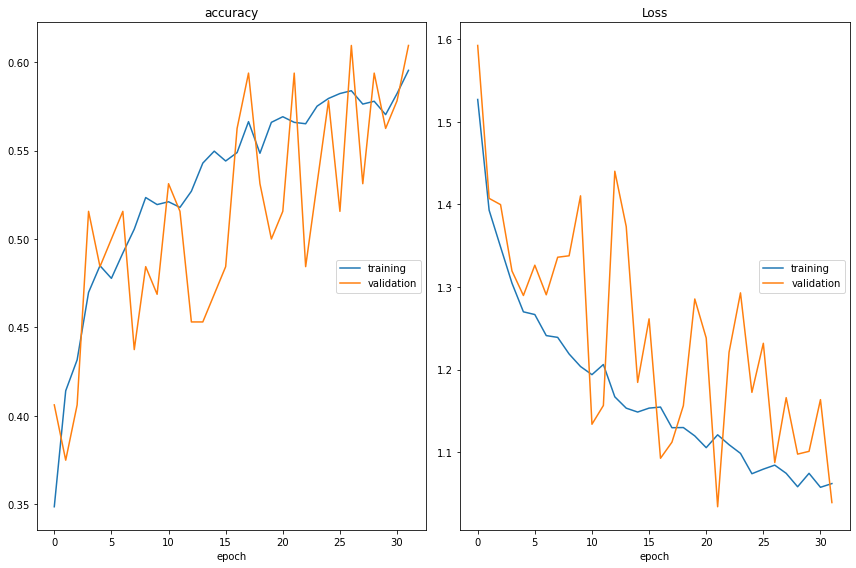

accuracy
	training         	 (min:    0.349, max:    0.595, cur:    0.595)
	validation       	 (min:    0.375, max:    0.609, cur:    0.609)
Loss
	training         	 (min:    1.058, max:    1.527, cur:    1.062)
	validation       	 (min:    1.034, max:    1.592, cur:    1.039)
CPU times: total: 2h 30min 45s
Wall time: 45min 36s


In [5]:
%%time

from tensorflow.keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping
from livelossplot import PlotLossesKeras

steps_per_epoch = traingen.samples // BATCH_SIZE
val_steps = validgen.samples // BATCH_SIZE

n_epochs = 100

optimizer = RMSprop(learning_rate=0.0001)

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Saves Keras model after each epoch
checkpointer = ModelCheckpoint(filepath='img_model.weights.best.hdf5', verbose=1, save_best_only=True)

# Early stopping to prevent overtraining and to ensure decreasing validation loss
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, mode='min')

# tensorboard_callback = TensorBoard(log_dir="./logs")

# Actual fitting of the model
history = model.fit(traingen, epochs=n_epochs, steps_per_epoch=steps_per_epoch, validation_data=validgen, validation_steps=val_steps, callbacks=[early_stop, checkpointer, PlotLossesKeras()], verbose=False)

#### Evaluating the Network


In [ ]:
test_generator = ImageDataGenerator(rescale=1/255.)

testgen = test_generator.flow_from_directory('data/train', target_size=(128, 128), batch_size=1, class_mode=None, shuffle=False, seed=42)


Found 521 images belonging to 6 classes.


In [ ]:
model.load_weights('img_model.weights.best.hdf5')

predicted_classes = np.argmax(model.predict(testgen), axis = 1)

class_indices = traingen.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())
true_classes = testgen.classes

#### Visualizing the Results

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

def display_results(y_true, y_preds, class_labels):
    
    results = pd.DataFrame(precision_recall_fscore_support(y_true, y_preds), columns=class_labels).T

    results.rename(columns={0: 'Precision', 1: 'Recall', 2: 'F-Score', 3: 'Support'}, inplace=True)
    
    results.sort_values(by='F-Score', ascending=False, inplace=True)                           
    global_acc = accuracy_score(y_true, y_preds)
    
    print("Overall Categorical Accuracy: {:.2f}%".format(global_acc*100))
    return results

def plot_predictions(y_true, y_preds, test_generator, class_indices):

    fig = plt.figure(figsize=(20, 10))
    for i, idx in enumerate(np.random.choice(test_generator.samples, size=20, replace=False)):
        ax = fig.add_subplot(4, 5, i + 1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(test_generator[idx]))
        pred_idx = y_preds[idx]
        true_idx = y_true[idx]
                
        plt.tight_layout()
        ax.set_title("{}\n({})".format(class_indices[pred_idx], class_indices[true_idx]), color=("green" if pred_idx == true_idx else "red"))

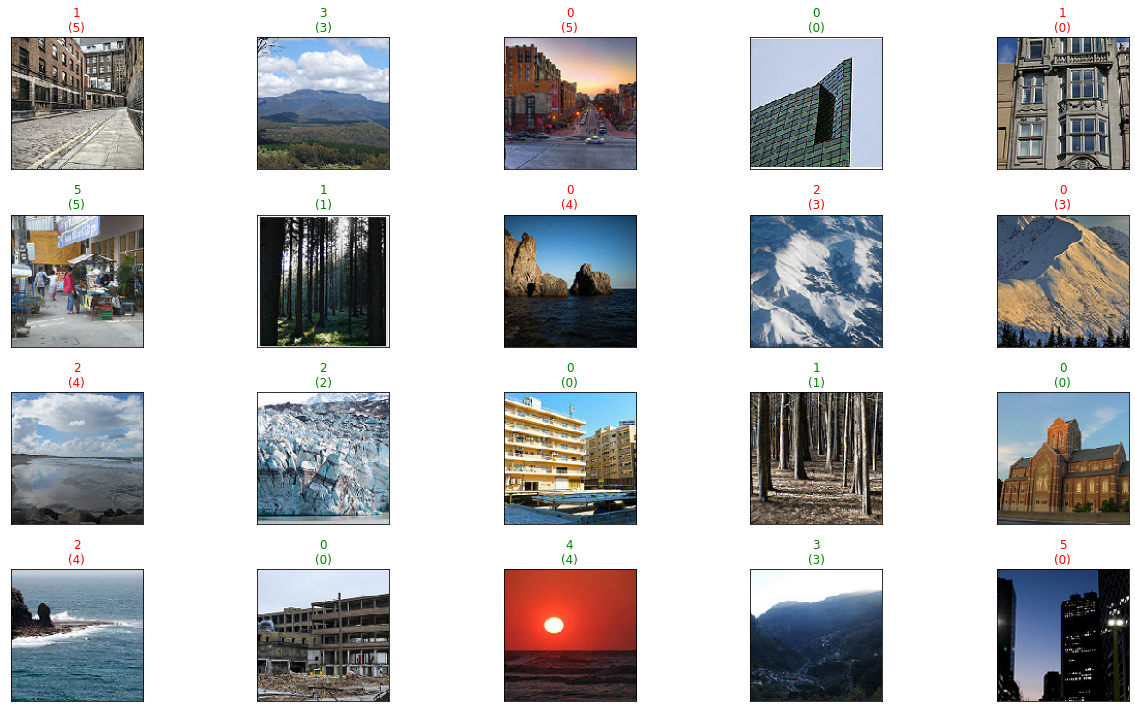

In [ ]:
plot_predictions(true_classes, predicted_classes, testgen, class_indices)


In [ ]:
display_results(true_classes, predicted_classes, class_indices.values())


Overall Categorical Accuracy: 53.74%


,Precision,Recall,F-Score,Support
1,0.622642,0.942857,0.750000,70.0
2,0.546512,0.587500,0.566265,80.0
0,0.469945,0.656489,0.547771,131.0
3,0.583333,0.437500,0.500000,80.0
5,0.531250,0.425000,0.472222,80.0
4,0.545455,0.150000,0.235294,80.0


## Experiment 2

In [ ]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

# ImageDataGenerator generates batches of tensor image data with real-time data augmentation.

train_generator = ImageDataGenerator(
    rescale=1/255.,              # normalize pixel values between 0-1
    brightness_range=[0.1, 0.7], # specify the range in which to decrease/increase brightness
    width_shift_range=0.5,       # shift the width of the image 50%
    rotation_range=90,           # random rotation by 90 degrees
    horizontal_flip=True,        # 180 degree flip horizontally
    vertical_flip=True,          # 180 degree flip vertically
    validation_split=0.15        # 15% of the data will be used for validation at end of each epoch
)

In [ ]:
BATCH_SIZE = 32

# flow_from_directory() takes the path to a directory & generates batches of augmented data.

traingen = train_generator.flow_from_directory('data/train', target_size=(128, 128), batch_size=BATCH_SIZE, class_mode='categorical', subset='training', shuffle=True, seed=42)

validgen = train_generator.flow_from_directory('data/valid', target_size=(128, 128), batch_size=BATCH_SIZE, class_mode='categorical', subset='validation', shuffle=True, seed=42)

Found 2559 images belonging to 6 classes.
Found 77 images belonging to 6 classes.


#### Define CNN Architecture in Keras

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation
from keras.regularizers import l1_l2
from keras.layers import BatchNormalization
model = Sequential()

#### Input Layer ####
model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same',
                 activation='relu', input_shape=(128, 128, 3)))

#### Convolutional Layers ####
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))  # Pooling
model.add(Dropout(0.2)) # Dropout
model.add(BatchNormalization())

model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(Activation('relu'))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.2))
model.add(BatchNormalization())

#### Fully-Connected Layer ####
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(6, activation='softmax'))

model.summary() # a handy way to inspect the architecture

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_26 (Conv2D)          (None, 128, 128, 32)      896       
                                                                 
 conv2d_27 (Conv2D)          (None, 126, 126, 32)      9248      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 63, 63, 32)       0         
 g2D)                                                            
                                                                 
 dropout_14 (Dropout)        (None, 63, 63, 32)        0         
                                                                 
 batch_normalization (BatchN  (None, 63, 63, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_28 (Conv2D)          (None, 63, 63, 64)       

In [ ]:
!pip install livelossplot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#### Training the network

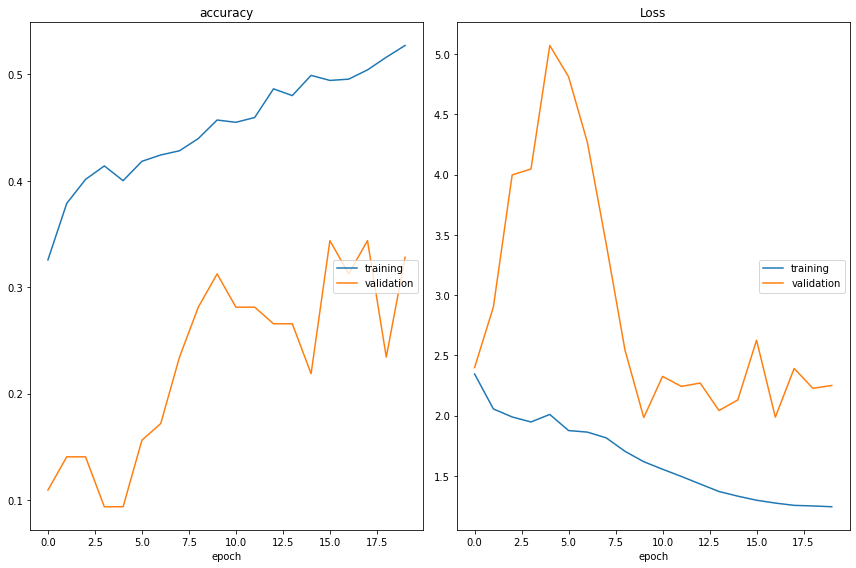

accuracy
	training         	 (min:    0.326, max:    0.527, cur:    0.527)
	validation       	 (min:    0.094, max:    0.344, cur:    0.328)
Loss
	training         	 (min:    1.243, max:    2.345, cur:    1.243)
	validation       	 (min:    1.983, max:    5.073, cur:    2.250)
CPU times: user 6min 58s, sys: 14.6 s, total: 7min 13s
Wall time: 7min 34s


In [ ]:
%%time

from tensorflow.keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping
from livelossplot import PlotLossesKeras

steps_per_epoch = traingen.samples // BATCH_SIZE
val_steps = validgen.samples // BATCH_SIZE

n_epochs = 100

optimizer = RMSprop(learning_rate=0.0001)

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Saves Keras model after each epoch
checkpointer = ModelCheckpoint(filepath='img_model.weights.best.hdf5', verbose=1, save_best_only=True)

# Early stopping to prevent overtraining and to ensure decreasing validation loss
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, mode='min')

# tensorboard_callback = TensorBoard(log_dir="./logs")

# Actual fitting of the model
history = model.fit(traingen, epochs=n_epochs, steps_per_epoch=steps_per_epoch, validation_data=validgen, validation_steps=val_steps, callbacks=[early_stop, checkpointer, PlotLossesKeras()], verbose=False)

#### Evaluating the Network


In [6]:
test_generator = ImageDataGenerator(rescale=1/255.)

testgen = test_generator.flow_from_directory('data/valid', target_size=(128, 128), batch_size=1, class_mode=None, shuffle=False, seed=42)


Found 521 images belonging to 6 classes.


In [7]:
model.load_weights('img_model.weights.best.hdf5')

predicted_classes = np.argmax(model.predict(testgen), axis = 1)

class_indices = traingen.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())
true_classes = testgen.classes

521/521 [==============================] - 9s 18ms/step


#### Visualizing the Results

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

def display_results(y_true, y_preds, class_labels):
    
    results = pd.DataFrame(precision_recall_fscore_support(y_true, y_preds), columns=class_labels).T

    results.rename(columns={0: 'Precision', 1: 'Recall', 2: 'F-Score', 3: 'Support'}, inplace=True)
    
    results.sort_values(by='F-Score', ascending=False, inplace=True)                           
    global_acc = accuracy_score(y_true, y_preds)
    
    print("Overall Categorical Accuracy: {:.2f}%".format(global_acc*100))
    return results

def plot_predictions(y_true, y_preds, test_generator, class_indices):

    fig = plt.figure(figsize=(20, 10))
    for i, idx in enumerate(np.random.choice(test_generator.samples, size=20, replace=False)):
        ax = fig.add_subplot(4, 5, i + 1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(test_generator[idx]))
        pred_idx = y_preds[idx]
        true_idx = y_true[idx]
                
        plt.tight_layout()
        ax.set_title("{}\n({})".format(class_indices[pred_idx], class_indices[true_idx]), color=("green" if pred_idx == true_idx else "red"))

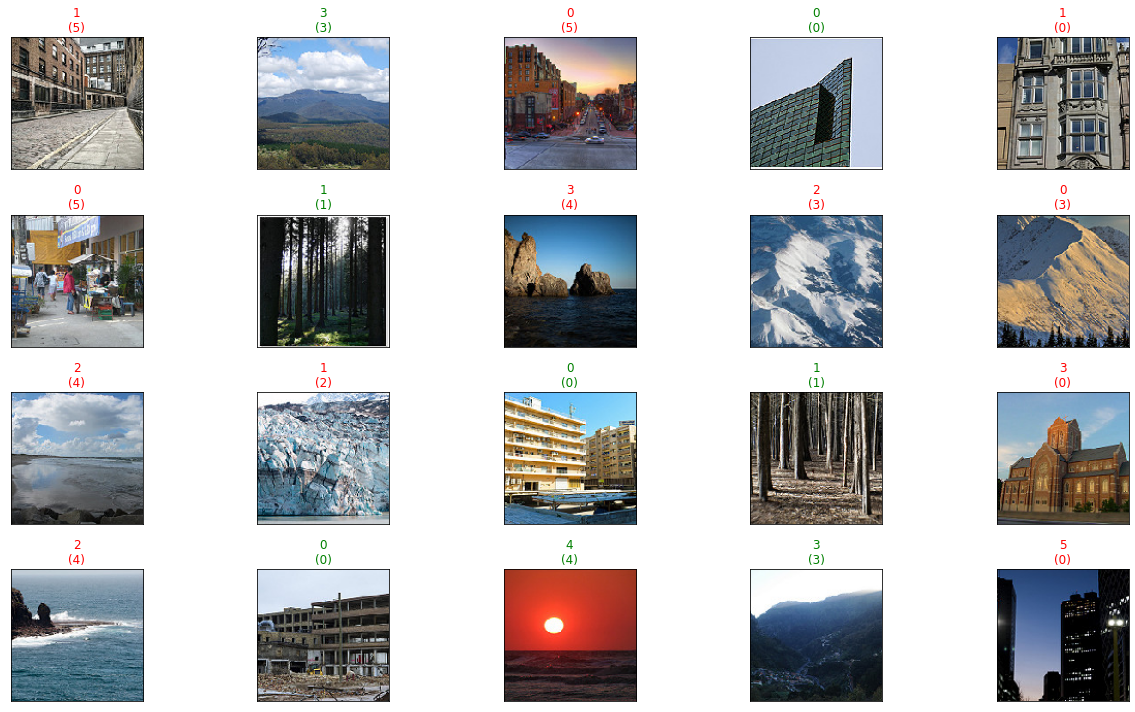

In [9]:
plot_predictions(true_classes, predicted_classes, testgen, class_indices)


In [10]:
display_results(true_classes, predicted_classes, class_indices.values())


Overall Categorical Accuracy: 51.82%


,Precision,Recall,F-Score,Support
1,0.544715,0.957143,0.694301,70.0
2,0.620253,0.612500,0.616352,80.0
0,0.464865,0.656489,0.544304,131.0
3,0.500000,0.500000,0.500000,80.0
4,0.625000,0.187500,0.288462,80.0
5,0.433333,0.162500,0.236364,80.0


## Experiment 3

In [11]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

# ImageDataGenerator generates batches of tensor image data with real-time data augmentation.

train_generator = ImageDataGenerator(
    rescale=1/255.,              # normalize pixel values between 0-1
    brightness_range=[0.1, 0.7], # specify the range in which to decrease/increase brightness
    width_shift_range=0.5,       # shift the width of the image 50%
    rotation_range=90,           # random rotation by 90 degrees
    horizontal_flip=True,        # 180 degree flip horizontally
    vertical_flip=True,          # 180 degree flip vertically
    validation_split=0.15        # 15% of the data will be used for validation at end of each epoch
)

In [12]:
BATCH_SIZE = 32

# flow_from_directory() takes the path to a directory & generates batches of augmented data.

traingen = train_generator.flow_from_directory('data/train', target_size=(128, 128), batch_size=BATCH_SIZE, class_mode='categorical', subset='training', shuffle=True, seed=42)

validgen = train_generator.flow_from_directory('data/valid', target_size=(128, 128), batch_size=BATCH_SIZE, class_mode='categorical', subset='validation', shuffle=True, seed=42)

Found 2550 images belonging to 6 classes.
Found 77 images belonging to 6 classes.


#### Define CNN Architecture in Keras

In [13]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation
from keras.regularizers import l1_l2
from keras.layers import BatchNormalization
from tensorflow.keras.initializers import GlorotUniform

initializer = GlorotUniform()
model = Sequential()

#### Input Layer ####
model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu', input_shape=(128, 128, 3)))

#### Convolutional Layers ####
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))  # Pooling
model.add(Dropout(0.2)) # Dropout
model.add(BatchNormalization())

model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(Activation('relu'))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.2))
model.add(BatchNormalization())

#### Fully-Connected Layer ####
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(6, kernel_initializer=initializer, activation='softmax'))

model.summary() # a handy way to inspect the architecture

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 128, 128, 32)      896       
                                                                 
 conv2d_7 (Conv2D)           (None, 126, 126, 32)      9248      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 63, 63, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 63, 63, 32)        0         
                                                                 
 batch_normalization (BatchN  (None, 63, 63, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_8 (Conv2D)           (None, 63, 63, 64)       

In [14]:
!pip install livelossplot


[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


#### Training the network

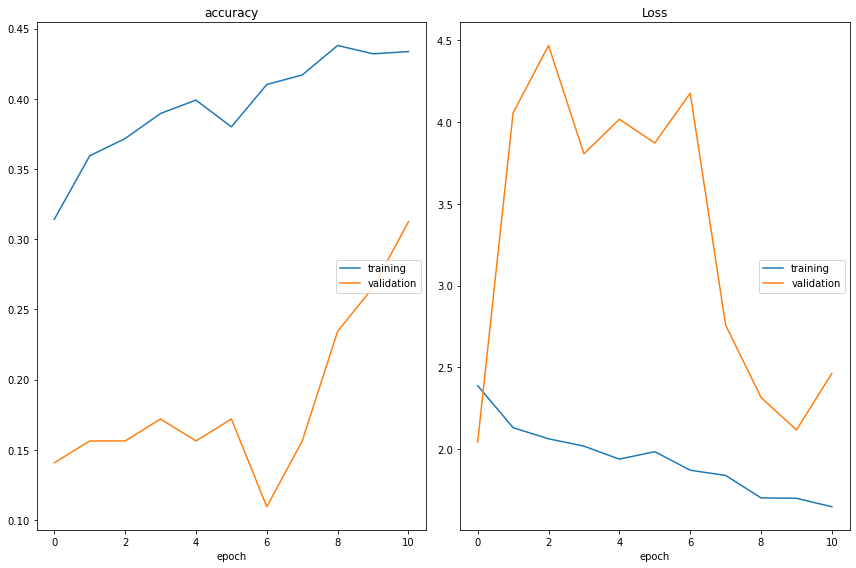

accuracy
	training         	 (min:    0.314, max:    0.438, cur:    0.434)
	validation       	 (min:    0.109, max:    0.312, cur:    0.312)
Loss
	training         	 (min:    1.648, max:    2.388, cur:    1.648)
	validation       	 (min:    2.045, max:    4.467, cur:    2.463)
CPU times: total: 1h 49s
Wall time: 16min 32s


In [15]:
%%time

from tensorflow.keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping
from livelossplot import PlotLossesKeras

steps_per_epoch = traingen.samples // BATCH_SIZE
val_steps = validgen.samples // BATCH_SIZE

n_epochs = 100

optimizer = RMSprop(learning_rate=0.0001)

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Saves Keras model after each epoch
checkpointer = ModelCheckpoint(filepath='img_model.weights.best.hdf5', verbose=1, save_best_only=True)

# Early stopping to prevent overtraining and to ensure decreasing validation loss
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, mode='min')

# tensorboard_callback = TensorBoard(log_dir="./logs")

# Actual fitting of the model
history = model.fit(traingen, epochs=n_epochs, steps_per_epoch=steps_per_epoch, validation_data=validgen, validation_steps=val_steps, callbacks=[early_stop, checkpointer, PlotLossesKeras()], verbose=False)

#### Evaluating the Network


In [16]:
test_generator = ImageDataGenerator(rescale=1/255.)

testgen = test_generator.flow_from_directory('data/valid', target_size=(128, 128), batch_size=1, class_mode=None, shuffle=False, seed=42)


Found 521 images belonging to 6 classes.


In [17]:
model.load_weights('img_model.weights.best.hdf5')

predicted_classes = np.argmax(model.predict(testgen), axis = 1)

class_indices = traingen.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())
true_classes = testgen.classes

521/521 [==============================] - 10s 19ms/step


#### Visualizing the Results

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

def display_results(y_true, y_preds, class_labels):
    
    results = pd.DataFrame(precision_recall_fscore_support(y_true, y_preds), columns=class_labels).T

    results.rename(columns={0: 'Precision', 1: 'Recall', 2: 'F-Score', 3: 'Support'}, inplace=True)
    
    results.sort_values(by='F-Score', ascending=False, inplace=True)                           
    global_acc = accuracy_score(y_true, y_preds)
    
    print("Overall Categorical Accuracy: {:.2f}%".format(global_acc*100))
    return results

def plot_predictions(y_true, y_preds, test_generator, class_indices):

    fig = plt.figure(figsize=(20, 10))
    for i, idx in enumerate(np.random.choice(test_generator.samples, size=20, replace=False)):
        ax = fig.add_subplot(4, 5, i + 1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(test_generator[idx]))
        pred_idx = y_preds[idx]
        true_idx = y_true[idx]
                
        plt.tight_layout()
        ax.set_title("{}\n({})".format(class_indices[pred_idx], class_indices[true_idx]), color=("green" if pred_idx == true_idx else "red"))

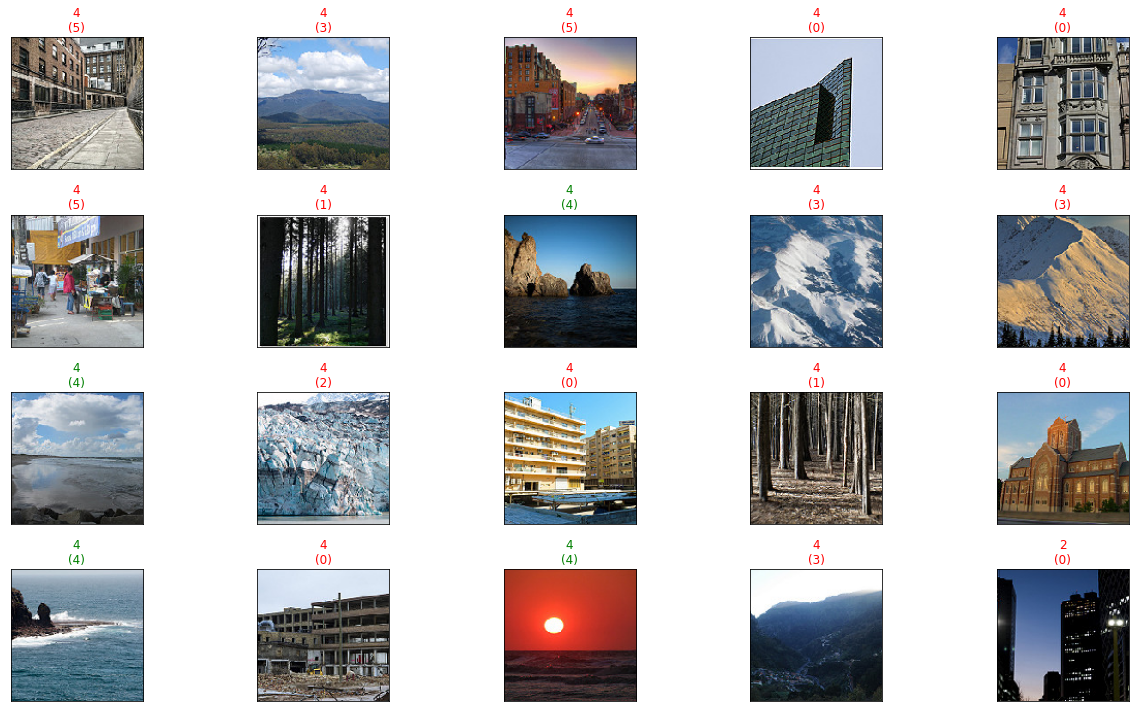

In [19]:
plot_predictions(true_classes, predicted_classes, testgen, class_indices)


In [20]:
display_results(true_classes, predicted_classes, class_indices.values())


Overall Categorical Accuracy: 16.31%


C:\Users\16474\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Precision,Recall,F-Score,Support
4,0.154786,0.950000,0.266200,80.0
2,0.285714,0.100000,0.148148,80.0
0,1.000000,0.007634,0.015152,131.0
1,0.000000,0.000000,0.000000,70.0
3,0.000000,0.000000,0.000000,80.0
5,0.000000,0.000000,0.000000,80.0


## Experiment 4

In [34]:
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator

In [31]:
model4 = Sequential()

# input
model4.add(Conv2D(32, kernel_size = (3, 3), activation = 'relu', input_shape = (256, 256, 3), data_format = "channels_last"))
model4.add(MaxPooling2D((2, 2)))

# hidden layers 
model4.add(Conv2D(32, (3, 3), activation = 'relu', kernel_regularizer = 'l2'))
model4.add(MaxPooling2D((2, 2)))

model4.add(Conv2D(64, (3, 3), activation = 'relu', kernel_regularizer = 'l2'))
model4.add(MaxPooling2D((2, 2)))

model4.add(Conv2D(64, (3, 3), activation = 'relu', kernel_regularizer = 'l2'))
model4.add(MaxPooling2D((2, 2)))

model4.add(Conv2D(64, (3, 3), activation = 'relu', kernel_regularizer = 'l2'))
model4.add(MaxPooling2D((2, 2)))

model4.add(Conv2D(32, (3, 3), activation = 'relu', kernel_regularizer = 'l2'))
model4.add(MaxPooling2D((2, 2)))


# flatten layer
model4.add(Flatten())

# dense hidden layer
model4.add(Dense(128, activation = 'relu'))

# output layer
model4.add(Dense(6, activation = 'softmax'))

In [32]:
# compile
model4.compile(loss = 'categorical_crossentropy', optimizer = "RMSprop", metrics = ['accuracy'])

## Discussion :

It can be observed at the classification report that glaciers has the highest error in prediction possible reason is that glaciers could be look like a mountain that even a human could the same mistake as well. Grad-Cam can really show how the machine think by showing where portion in the photos its focusing on. The model obtained a high score in accuracy but this could be further improve by tuning the model or more experimentation in image augmentation. 